## Imports

In [5]:
!pip3 install pyannote.audio --quiet

In [6]:
import glob
import IPython.display as ipd
import torch
from pprint import pprint
from pyannote.audio import Pipeline

## Data

In [8]:
## Uncomment to add kaggle.json in Google Collab
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":""}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
## Uncomment it to download kaggle VCTK dataset
!kaggle datasets download -d mfekadu/english-multispeaker-corpus-for-voice-cloning
!mkdir ../../data
!unzip -qq english-multispeaker-corpus-for-voice-cloning.zip -d ../../data
# -qq # to do it quiet

In [10]:
wave_pathes = glob.glob(
    "../../data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)
# In case of Windows
# wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]
sample_file = wave_pathes[0]
ipd.Audio(sample_file)

## Pseudo-labels based example Silero VAD

In [11]:
model, utils = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad", force_reload=True)
get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


In [12]:
wav = read_audio(wave_pathes[0])
ipd.Audio(wave_pathes[0])

In [13]:
speech_timestamps = get_speech_timestamps(wav, model)
pprint(speech_timestamps)

[{'end': 54240, 'start': 18976}]


In [14]:
save_audio("only_speech.wav", collect_chunks(speech_timestamps, wav))
ipd.Audio("only_speech.wav")

## Example of prediction based on pyannotate

In [16]:
HUGGING_FACE_ACCESS_TOKEN = ""
pipeline = Pipeline.from_pretrained("pyannote/voice-activity-detection",
                                    use_auth_token=HUGGING_FACE_ACCESS_TOKEN)


config.yaml:   0%|          | 0.00/277 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.2.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.1.0+cu121. Bad things might happen unless you revert torch to 1.x.


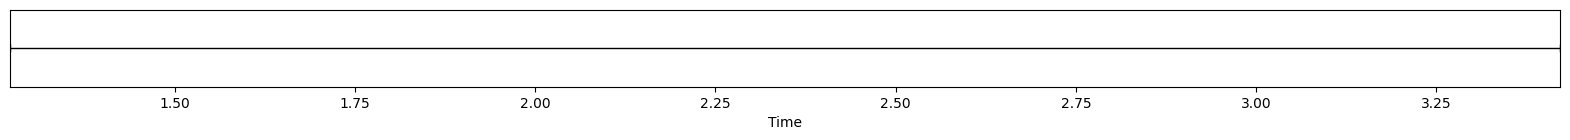

In [17]:
# The result are pretty bad, as silence in the beginning isn't detected
output = pipeline(wave_pathes[0])
output.get_timeline()

In [18]:
# How to extract labels?
[{"start": segment.start, "end": segment.end, "label": label} for segment, _, label in output.itertracks(yield_label=True)]

[{'start': 1.271331058020478, 'end': 3.4215017064846416, 'label': 'SPEECH'}]

## Metric evaluation

In [84]:
from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionErrorRate
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

metric = DetectionErrorRate()

for file in tqdm(wave_pathes[:1000], desc="Processing files", unit="file"):
    wav = read_audio(file)
    speech_timestamps = get_speech_timestamps(wav, model)
    reference = Annotation()

    for speech in speech_timestamps:
      reference[Segment(speech["start"] / 16000, speech["end"] / 16000)] = "SPEECH"

    hypothesis = pipeline(file)

    # evaluate its output
    _ = metric(
        reference,      # this is the reference annotation
        hypothesis)     # this is the hypothesized annotation

# aggregate the performance over the whole test set
detection_error_rate = abs(metric)
print(f'\n\nDetection error rate = {detection_error_rate * 100:.1f}%')

Processing files: 100%|██████████| 1000/1000 [05:48<00:00,  2.87file/s]



Detection error rate = 11.6%


## Homework
1. Implement your own rule-based VAD
2. Compare it to pyannote (you should receive a better performance on the whole dataset)

Algorithm explanation:

1. **Calculating Energy**:
First step is to divide the signal into frames and compute the energy of each frame by summing the squared values of its samples. By doing this, we can calculate the energy throughout the audio.

2. **Thresholding**:
Next step is to compare those energies to a predefined threshold.
- If the energy > than the threshold and speech is not already detected, set a mark as the start of a speech segment.
- If the energy falls below the threshold and speech is currently detected, set the mark as the end of the speech segment.

3. **Segmentation**:
Then we need to combine the adjacent speech segments if the gap between them is smaller than a maximum silence duration. This prevents from having a lot of small gaps.

In [61]:
def calculate_DER(reference, hypothesis):
    metric = DetectionErrorRate()
    _ = metric(reference, hypothesis)
    return abs(metric)

In [112]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def calculate_energy(signal, frame_length, hop_length):
    """
    Calculate the energy of frames in an audio signal.
    """
    energy = []
    for i in range(0, len(signal) - frame_length, hop_length):
        energy.append(np.sum(np.square(signal[i:i+frame_length])))
    return np.array(energy)


def combine_segments(segments, max_silence_duration):
    """
    Combine segments separated by small duration of silence.
    """
    if len(segments) == 0: return []

    combined_segments = []
    last_start, last_end = segments[0]
    for start, end in segments[1:]:
        if start - last_end <= max_silence_duration:
            last_end = end
        else:
            combined_segments.append((last_start, last_end))
            last_start, last_end = start, end
    combined_segments.append((last_start, last_end))

    return combined_segments


def vad(signal, max_silence_duration, energy_threshold=0.1, frame_length=1024, hop_length=512):
    """
    Performing voice activity detection
    """
    # calculating energies
    energy = calculate_energy(signal, frame_length, hop_length)

    speech_segments = []
    is_speech = False
    speech_start = 0

    for i, e in enumerate(energy):
        if e > energy_threshold and not is_speech:
            is_speech = True
            speech_start = i * hop_length
        elif e <= energy_threshold and is_speech:
            is_speech = False
            speech_segments.append((speech_start, i * hop_length))

    # checking if speech extends to the end of the signal
    if is_speech: speech_segments.append((speech_start, len(signal)))
    # combining segments seperated by small duration of silence `max_silence_duration`
    combined_segments = combine_segments(speech_segments, max_silence_duration)

    return combined_segments

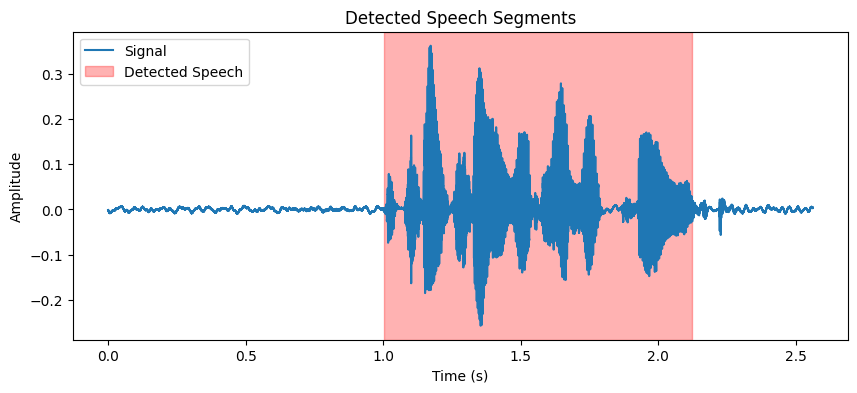

Speech Segment 1: Start Time - 1.0026666666666666 s, End Time - 2.1226666666666665 s


In [113]:
# example of usage
filename = wave_pathes[10]
signal, sr = librosa.load(filename, sr=None)

speech_segments = vad(signal, sr/4, energy_threshold=0.2)

# ploting the signal and detected speech segments
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(signal)) / sr, signal, label='Signal')
for start, end in speech_segments:
    plt.axvspan(start / sr, end / sr, color='red', alpha=0.3, label='Detected Speech')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Detected Speech Segments')
plt.legend()
plt.show()


for i, (start, end) in enumerate(speech_segments):
    print(f"Speech Segment {i+1}: Start Time - {start/sr} s, End Time - {end/sr} s")

In [97]:
metric = DetectionErrorRate()
i = 0

for file in tqdm(wave_pathes[:1000], desc="Processing files", unit="file"):
    wav = read_audio(file)
    wav_sr = 16000
    signal, sr = librosa.load(file, sr=None)

    speech_timestamps = get_speech_timestamps(wav, model)
    reference = Annotation()
    for speech in speech_timestamps:
      reference[Segment(speech["start"] / wav_sr, speech["end"] / wav_sr)] = "SPEECH"

    hypothesis_segments = vad(signal, sr/4, energy_threshold=0.2)
    hypothesis = Annotation()
    for segment in hypothesis_segments:
        hypothesis[Segment(segment[0] / sr, segment[1] / sr)] = "SPEECH"

    # evaluate its output
    _ = metric(
        reference,      # this is the reference annotation
        hypothesis)     # this is the hypothesized annotation

# aggregate the performance
detection_error_rate = abs(metric)
print(f'\n\nDetection error rate = {detection_error_rate * 100:.1f}%')

Processing files: 100%|██████████| 1000/1000 [04:19<00:00,  3.86file/s]




Detection error rate = 8.4%


The output shows that the
Detection error rate = 8.4% on 1000 datapoints

Let's plot several examples

i: 0
hypothesis: [ 00:00:01.226 -->  00:00:03.317] _ SPEECH
reference: [ 00:00:01.186 -->  00:00:03.390] _ SPEECH


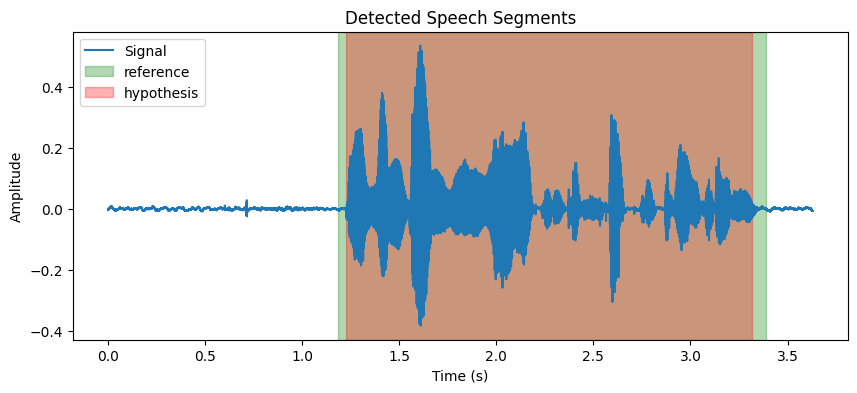

i: 1
hypothesis: [ 00:00:00.906 -->  00:00:02.282] _ SPEECH
reference: [ 00:00:00.898 -->  00:00:02.366] _ SPEECH


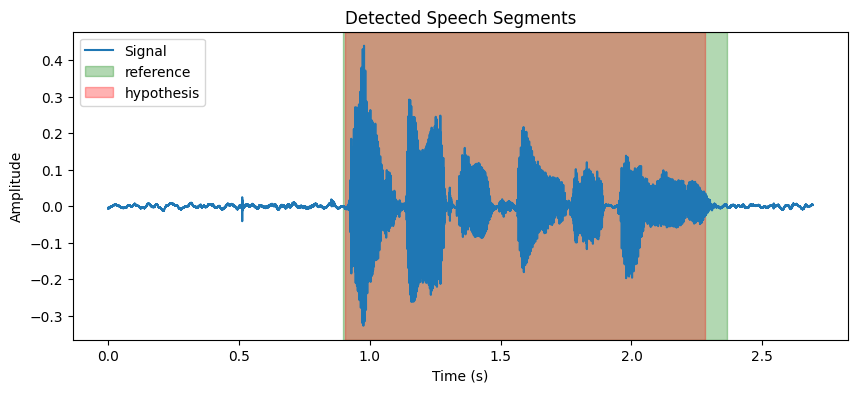

i: 2
hypothesis: [ 00:00:00.960 -->  00:00:03.157] _ SPEECH
reference: [ 00:00:00.930 -->  00:00:03.262] _ SPEECH


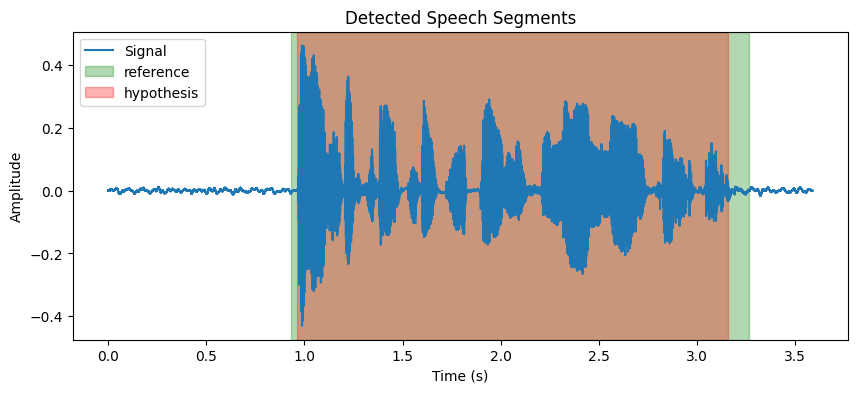

In [100]:
i = 0
for file in wave_pathes[0:3]:
    wav = read_audio(file)
    wav_sr = 16000
    signal, sr = librosa.load(file, sr=None)

    speech_timestamps = get_speech_timestamps(wav, model)
    reference = Annotation()
    for speech in speech_timestamps:
      reference[Segment(speech["start"] / wav_sr, speech["end"] / wav_sr)] = "SPEECH"

    hypothesis_segments = vad(signal, sr/4, energy_threshold=0.2)
    hypothesis = Annotation()
    for segment in hypothesis_segments:
        hypothesis[Segment(segment[0] / sr, segment[1] / sr)] = "SPEECH"

    print(f'i: {i}')
    i += 1
    print(f'hypothesis: {hypothesis}')
    print(f'reference: {reference}')

    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(signal)) / sr, signal, label='Signal')
    for speech in speech_timestamps:
        plt.axvspan(speech["start"] / wav_sr, speech["end"] / wav_sr, color='green', alpha=0.3, label='reference')
    for segment in hypothesis_segments:
        plt.axvspan(segment[0] / sr, segment[1] / sr, color='red', alpha=0.3, label='hypothesis')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Detected Speech Segments')
    plt.legend()
    plt.show()

So the result with own algorithm are better then pyannote model.

8.4 % vs 11 %